# 3章 組み合わせのあるテスト：　要素に分解して考える

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

## 3.1 チャーリーのレポート
ヒーロー画像とボタンの表示を変えた、4つの組み合わせのクリック率をMCMCで推論する。


|ヒーロー画像|ボタン|表示回数|クリック回数|クリック率|
|:-:|:-:|:-:|:-:|:-:|
|A|商品イメージ|434|8|1.84%|
|B|商品イメージ|382|17|4.45%|
|C|サンプル写真|394|10|2.54%|
|D|サンプル写真|88|4|4.55%|


事前分布には一様分布を仮定し、尤度関数が二項分布のモデル

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 8 seconds.


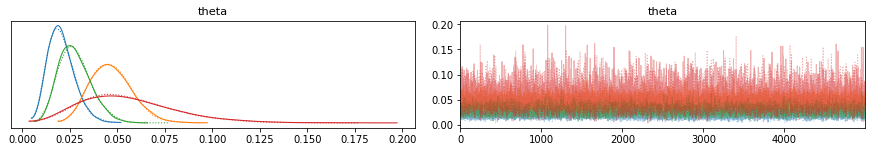

In [ ]:
# A,B,C,Dの表示回数
n = [434, 382, 394, 88]
# クリック数
clicks = [8,17,10, 4]

with pm.Model() as model:
  theta = pm.Uniform('theta', lower=0, upper=1, shape=len(n))
  obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
  trace = pm.sample(5000, chains=2)
  pm.traceplot(trace, compact=True)

↑青がA、オレンジがB、,緑がC、赤がD

In [ ]:
with model:
  display(pm.summary(trace, hdi_prob=0.95))

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta[0],0.021,0.007,0.008,0.034,0.0,0.0,12538.0,11394.0,12254.0,6960.0,1.0
theta[1],0.047,0.011,0.027,0.068,0.0,0.0,15895.0,14186.0,16166.0,7969.0,1.0
theta[2],0.028,0.008,0.013,0.045,0.0,0.0,12986.0,11394.0,13270.0,7758.0,1.0
theta[3],0.056,0.024,0.015,0.105,0.0,0.0,12056.0,10331.0,11944.0,6995.0,1.0


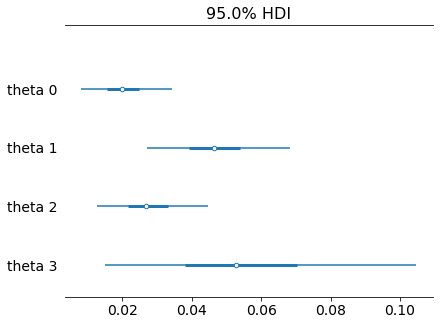

In [ ]:
with model:
  pm.forestplot(trace, combined=True, hdi_prob=0.95)

In [ ]:
#AとBのデザインを比較
print((trace['theta'][:, 1] - trace['theta'][:, 0] > 0).mean())

0.9828


In [ ]:
# AとDを比較
print((trace['theta'][:, 3] - trace['theta'][:, 0] > 0).mean())

0.9455


Bのクリック率は、Aよりも高いと結論づけることができる。
AとDを比較すると、判断基準の95%を下回っているので、DはAよりクリック率が高いと言うことはできない

## 3.2　効果に着目したモデリング

4つのデザインのうち、どれが優れているかよりもヒーロー画像、ボタンの各要素がクリック率に与える効果を知りたい。今後ほかのWebページを作成するときにも活かせる

### ロジスティック関数

ダミー変数(0,1)を導入し、ヒーロー画像の変数をを$x_1$、ボタンの変数$x_2$とする。<br>
ベースラインとなる切片を$\alpha$とし、変数($x_1$)にかかる係数(ヒーロー画像のクリック率への貢献分)を$\beta_1$、変数($x_2$)にかかる係数(ボタンのクリック率への貢献分)を$\beta_2$とする。

$$
 logistic(x) = \frac{1}{1+ e^{-x}}
$$

$$
\theta = logistic(\alpha + \beta_1x_1 + \beta_2x_2)
$$



ロジット関数 <br>
$$logit(x) = log( \frac{x}{1-x} )$$
を使って、クリック率$\theta$を表現すると、
$$
  logit(\theta) = \alpha + \beta_1x_1 + \beta_2x_2
$$

効果の大きさ、$\beta_1$、$\beta_2$の確率変数に対する事前分布を正規分布として仮定する。
正規分布の平均$\mu$を0とし、標準偏差$\sigma$を大きめにとった事前分布を仮定することで、0の周りに値が分布しつつ、広い範囲に値をとることができる。
同様に、$\alpha$の事前分布にも正規分布を使う。

## 3.3 統計モデルを書き直す

In [13]:
# ダミー変数
img = [0, 0 ,1 ,1]
btn = [0, 1, 0, 1]

with pm.Model() as model_comb:
  # アルファの事前分布を平均0、分散10の正規分布とする。
  alpha = pm.Normal('alpha', mu=0, sigma=10)
  # ベータの事前分布。shape=2とすることで、2変数表現できる
  beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
  # 一旦線形和をとった変数をcombとしておく
  comb = alpha + beta[0] * img + beta[1] *btn
  # ロジスティック関数
  theta = pm.Deterministic('theta', 1 / (1+pm.math.exp(-comb)))
  # 尤度関数は二項分布
  obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
  trace_comb = pm.sample(5000, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 14 seconds.


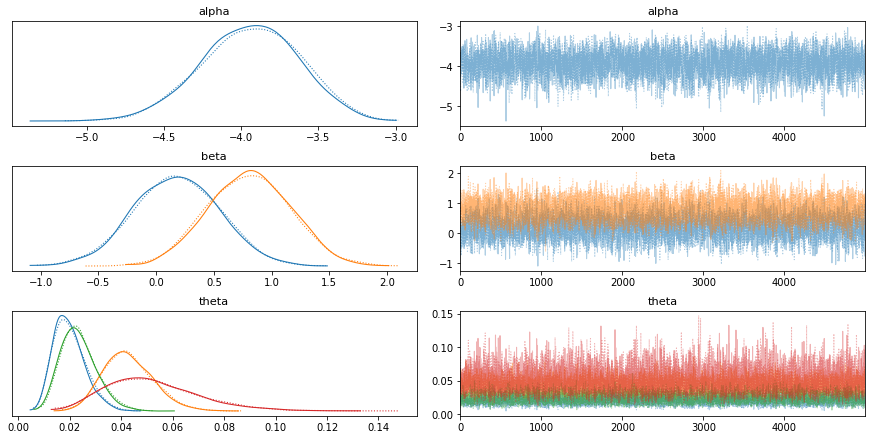

In [15]:
with model_comb:
  pm.traceplot(trace_comb)

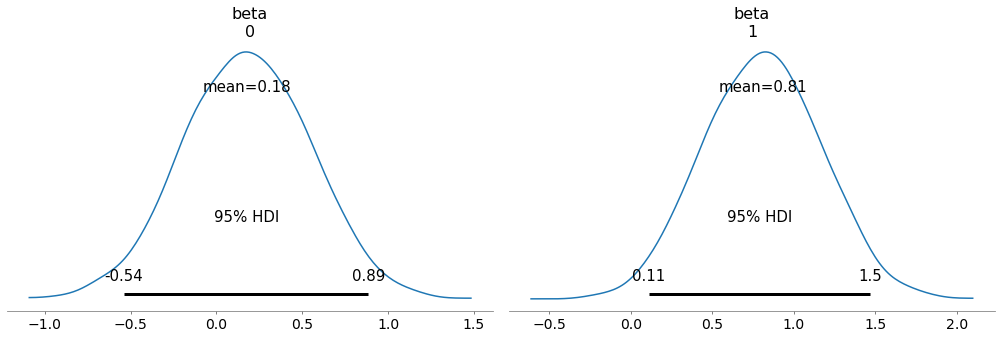

In [17]:
# ベータの事後分分布
with model_comb:
  pm.plot_posterior(trace_comb, var_names=['beta'], hdi_prob=0.95)

In [18]:
# ボタンを変えることの効果の検証
print((trace_comb['beta'][:, 1] > 0).mean())

0.9917


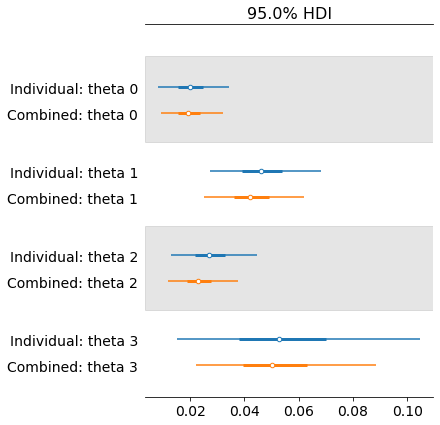

In [19]:
# 以前のモデルと効果に着目したモデルのHDIの比較
# 4つすべて区間が短くなる
with pm.Model():
  pm.forestplot([trace, trace_comb], var_names=['theta'],
                 hdi_prob=0.95, combined=True,
                 model_names=['Individual', 'Combined'])

In [20]:
# AとBの比較
print((trace_comb['theta'][:, 1] - trace_comb['theta'][:, 0] > 0).mean())
# AとDの比較
print((trace_comb['theta'][:, 3] - trace_comb['theta'][:, 0] > 0).mean())

0.9917
0.9532


## 3.4 完成したレポート、間違ったモデル
### 3.4.1 交互作用

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8929022950314233, but should be close to 0.8. Try to increase the number of tuning steps.


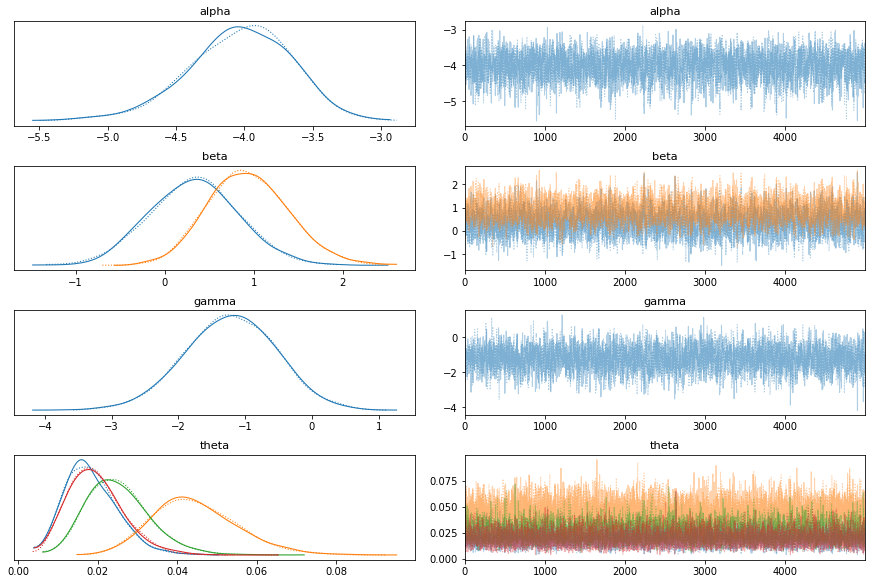

In [27]:
#　Dのパイプラインにバグがあったので、データが変わる
# A,B,C,Dの表示回数
n = [434, 382, 394, 412]
# クリック数
clicks = [8,17,10, 8]

# ダミー変数
img = [0, 0 ,1 ,1]
btn = [0, 1, 0, 1]

with pm.Model() as model_comb2:
  # アルファの事前分布を平均0、分散10の正規分布とする。
  alpha = pm.Normal('alpha', mu=0, sigma=10)
  # ベータの事前分布。shape=2とすることで、2変数表現できる
  beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
  # 一旦線形和をとった変数をcombとしておく
  comb = alpha + beta[0] * img + beta[1] *btn
  # ロジスティック関数
  theta = pm.Deterministic('theta', 1 / (1+pm.math.exp(-comb)))
  # 尤度関数は二項分布
  obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
  trace_comb2 = pm.sample(5000, chains=2)
  pm.traceplot(trace_int, compact=True)

ヒーロー画像とボタンの文言を変更することによる交互作用をモデルに加える
交互作用の効果を表す確率変数$\gamma$を追加し、クリック率\thetaを以下のようにする。

$$
\theta = logistic(\alpha + \beta_1x_1 + \beta_2x_2 + \gamma x_1 x_2)
$$



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [gamma, beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


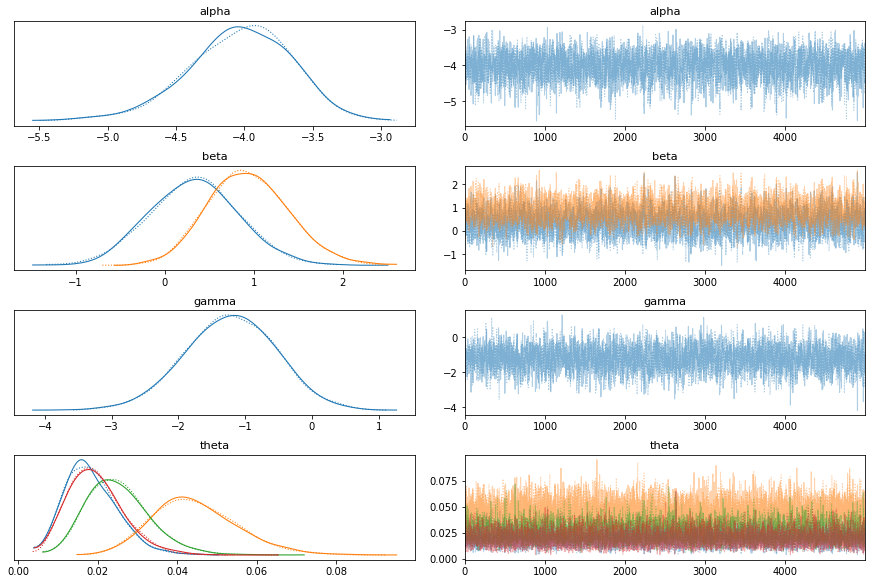

In [22]:
with pm.Model() as model_int:
  # アルファの事前分布を平均0、分散10の正規分布とする。
  alpha = pm.Normal('alpha', mu=0, sigma=10)
  # ベータの事前分布。shape=2とすることで、2変数表現できる
  beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
  # ガンマの事前分布を平均0、分散10の正規分布とする。
  gamma = pm.Normal('gamma', mu=0, sigma=10)
  # 一旦線形和をとった変数をcombとしておく
  comb = alpha + beta[0] * img + beta[1] *btn + gamma*img*btn
  # ロジスティック関数
  theta = pm.Deterministic('theta', 1 / (1+pm.math.exp(-comb)))
  # 尤度関数は二項分布
  obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
  trace_int = pm.sample(5000, chains=2)
  pm.traceplot(trace_int, compact=True)

In [25]:
# 交互作用の効果
print((trace_int['gamma'] < 0).mean())

0.9669


In [24]:
# ヒーロー画像の効果
print((trace_int['beta'][:, 0] > 0).mean())
# ボタンの効果
print((trace_int['beta'][:, 1] > 0).mean())

0.7476
0.9865


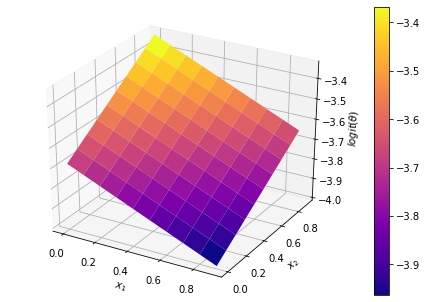

In [28]:
from mpl_toolkits.mplot3d import Axes3D

x1 = np.arange(0, 1, 0.1)
x2 = np.arange(0, 1, 0.1)
X1, X2 = np.meshgrid(x1, x2)
fig = plt.figure()
ax = Axes3D(fig)
logit_theta = (trace_comb2['alpha'].mean() +
      trace_comb2['beta'][:, 0].mean() * X1 +
      trace_comb2['beta'][:, 1].mean() * X2)
surf = ax.plot_surface(X1, X2, logit_theta, cmap='plasma')
fig.colorbar(surf)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$logit(\theta)$')
plt.show()

交互作用のないモデル

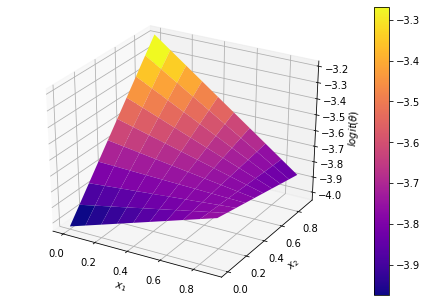

In [29]:
x1 = np.arange(0, 1, 0.1)
x2 = np.arange(0, 1, 0.1)
X1, X2 = np.meshgrid(x1, x2)
fig = plt.figure()
ax = Axes3D(fig)
Y = (trace_int['alpha'].mean() +
      trace_int['beta'][:, 0].mean() * X1 +
      trace_int['beta'][:, 1].mean() * X2 +
      trace_int['gamma'].mean() * X1 * X2)
surf = ax.plot_surface(X1, X2, Y, cmap='plasma')
fig.colorbar(surf)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$logit(\theta)$')
plt.show()

交互作用のあるモデル<br>
曲面になっている

### モデルの評価
#### AIC
AIC = -2 *対数尤度 + 2*パラメータ数 <br>
データへの当てはまり度(尤度) が大きいほど、パラメータ数が少ないほど小さくなる => 良いモデル

#### WAIC
WAIC(widely applicable information criterion) <br>
AICを一般化し、広いモデルにも適用できる指標 <br>
MCMCに結果から簡単に計算可能
https://www.slideshare.net/simizu706/waic

- データと予測分布の距離が小さいほど小さい
- パラメータの数が少ないほど小さい
- パラメータの分散が小さいほど小さい



In [31]:
waic_comb2 = pm.waic(trace_comb2, model_comb2)
waic_int = pm.waic(trace_int, model_int)
# 主効果のみ
print(waic_comb2.p_waic)
# 交互作用
print(waic_int.p_waic)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1415: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


3.725781074252905
2.14334295550222
